# Error Analysis

First, let's look at the scores. Although these are the scores for a specific run, they represent pretty truly what happens in general since we make sure that every run divides the training/test sets with respect to the various tags.

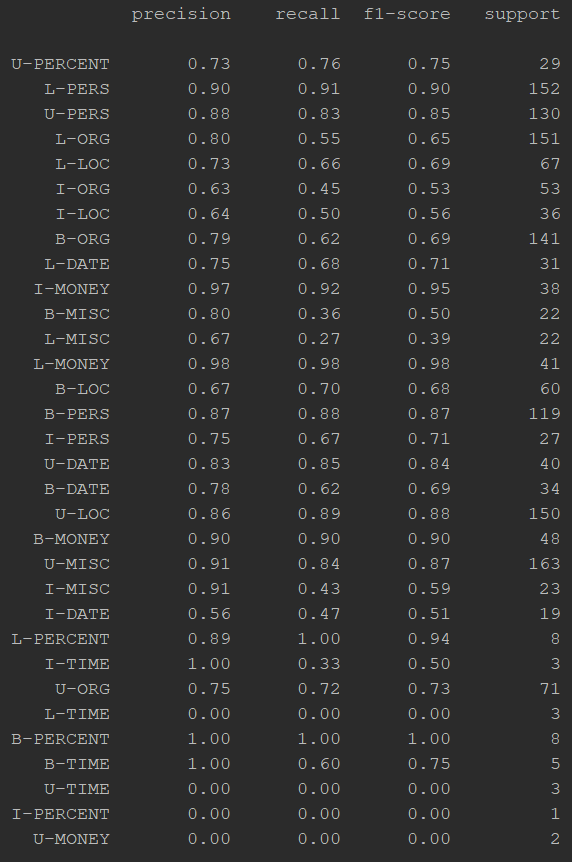

In [1]:
from IPython.display import Image
Image("scores.png")

We'll go over the various tags while trying to understand what went wrong and make suggestion(s) as how can we improve, especially for those with bad scores (under 0.8 fscore).
We'll show examples that demonstrate the mistakes/suggestions strongly, but won't go over every mistake. The examples will always be such that the idea they convey appeared multiple times.

In [2]:
import pandas as pd
import os
pd.options.display.max_rows = 300
data_path = 'X_test_with_predictions.csv'  # contains real and predicted tags
df = pd.read_csv(data_path)
data_path = 'dataset_biluo.csv' # contains all data sequentially
df_BILUO = pd.read_csv(data_path)
all_words = df_BILUO[df_BILUO['BILUO'] != 'NO-TAG']

## MISC

### B-MISC

In [3]:
spec_class_data = df[(df['y_test'] == 'B-MISC') & (df['y_test'] != df['y_pred'])]
print (len(spec_class_data))
spec_class_data[['Token','y_pred','y_test']]

14


,Token,y_pred,y_test
1793,הישראלית,U-MISC,B-MISC
3225,מפתח,O,B-MISC
4255,למלחמת,O,B-MISC
4895,מרדף,O,B-MISC
6308,להרוג,O,B-MISC
6498,להרוג,O,B-MISC
6838,להרוג,O,B-MISC
7236,ילדות,O,B-MISC
7243,ביום,B-DATE,B-MISC
7412,מומר,U-MISC,B-MISC


3 of the mistakes were in the word 'להרוג'. Checking their context produced the following:

In [4]:
inspection = df_BILUO[(df_BILUO['Token'] == 'להרוג') & (df_BILUO['BILUO'] == 'B-MISC')]
inspection[['Token', 'BILUO', 'Pos']]

,Token,BILUO,Pos
29426,להרוג,B-MISC,verb
29592,להרוג,B-MISC,verb
29673,להרוג,B-MISC,verb
29684,להרוג,B-MISC,verb


In [5]:
inspect = [29426, 29592, 29673, 29684]
for i in inspect:
    display (all_words[['Token', 'BILUO', 'Pos']][i-5:i+5])

,Token,BILUO,Pos
29421,לאור,O,preposition
29422,אחד,O,numeral
29423,מספריו,O,noun
29424,",",O,punctuation
29425,"""",O,punctuation
29426,להרוג,B-MISC,verb
29427,את,I-MISC,at-preposition
29428,הכלב,I-MISC,noun
29429,השני,L-MISC,noun
29430,"""",O,punctuation


,Token,BILUO,Pos
29587,אלה,O,pronoun
29588,מופיעים,O,participle
29589,במיוחד,O,adverb
29590,ב,O,preposition
29591,"""",O,punctuation
29592,להרוג,B-MISC,verb
29593,את,I-MISC,at-preposition
29594,הכלב,I-MISC,noun
29595,השני,L-MISC,noun
29596,"""",O,punctuation


,Token,BILUO,Pos
29668,הם,O,copula
29669,נזקקים,O,noun
29670,לכלב,O,noun
29671,.,O,punctuation
29672,"""",O,punctuation
29673,להרוג,B-MISC,verb
29674,את,I-MISC,at-preposition
29675,הכלב,I-MISC,noun
29676,השני,L-MISC,noun
29677,"""",O,punctuation


,Token,BILUO,Pos
29679,או,O,conjunction
29680,בתרגום,O,noun
29681,מהמקור,O,noun
29682,הפולני,U-MISC,noun
29683,"""",O,punctuation
29684,להרוג,B-MISC,verb
29685,את,I-MISC,at-preposition
29686,הכלב,I-MISC,noun
29687,בשנית,L-MISC,noun
29688,"""",O,punctuation


As we can see, the problematic word appeard as a part of a book name, but if we had regarded the sentence 'להרוג את הכלב' on it's own, the tag 'O' would have been ok. 
Two possible fixes: 
1) Add a feature of 'inside quotation marks' and also the length of the expression in the quotation marks (in order to differentiate it from speech. Usually, books, movies and plays names won't be as long as sentences in a conversation). We'll see more examples later - in fact, most of the mistakes with MISC occured with words inside quotation marks.
2) Add a feature to recognize ngrams. If the ngram appears more than once, it should be suspected as a name of something, and therefore a MISC. This won't help U-MISC, but the score there was pretty good anyway. Since the frequency of ngrams is usually low, this feature shouldn't affect anything else, but if we have statistics of what ngrams are expected in Hebrew, we can check there and exclude all of these (similar to TFIDF idea).

The word 'יהודים' appears alone usually, and therefore it's tagged U-MISC_AFF. Since the word appeared a lot of times in the corpus, the tagger relied on it and tagged it as a standalone word. In this 2 specific cases - 'יהודים דתיים', 'יהודים חרדיים' - the group name was consisted of 2 words. Therefore, the tagger wasn't wrong, but we might suggest a fix to add a feature of the predicted tag of the next word (which means that we'll have to do the learning twice).

### I-MISC

In [6]:
spec_class_data = df[(df['y_test'] == 'I-MISC') & (df['y_test'] != df['y_pred'])]
spec_class_data[['Token','y_pred','y_test']][0:1]

,Token,y_pred,y_test
925,שנות,B-DATE,I-MISC


In addition to another mistake with DATE above, lets inspect both:

In [7]:
inspection = df_BILUO[((df_BILUO['Token'] == 'שנות') & (df_BILUO['BILUO'] == 'I-MISC')) | ((df_BILUO['Token'] == 'ביום') & (df_BILUO['BILUO'] == 'B-MISC'))]
inspection[['Token', 'BILUO', 'Pos']]

,Token,BILUO,Pos
29451,ביום,B-MISC,noun
30710,שנות,I-MISC,noun
31501,ביום,B-MISC,noun


In [8]:
inspect = [29451, 30710, 31501]
for i in inspect:
    display (all_words[['Token', 'BILUO', 'Pos']][i-5:i+5])

,Token,BILUO,Pos
29446,",",O,punctuation
29447,כמו,O,preposition
29448,שלושה,O,numeral
29449,אחרים,O,adjective
29450,"""",O,punctuation
29451,ביום,B-MISC,noun
29452,מותו,L-MISC,noun
29453,"""",O,punctuation
29454,",",O,punctuation
29455,"""",O,punctuation


,Token,BILUO,Pos
30705,לאוטוביוגרפיה,O,noun
30706,שפרסם,O,verb
30707,",",O,punctuation
30708,"""",O,punctuation
30709,יפות,B-MISC,adjective
30710,שנות,I-MISC,noun
30711,העשרים,L-MISC,numeral
30712,"""",O,punctuation
30713,",",O,punctuation
30714,הוא,O,copula


,Token,BILUO,Pos
31496,",",O,punctuation
31497,כדי,O,quantifier
31498,להשתתף,O,verb
31499,בהסרטת,O,noun
31500,"""",O,punctuation
31501,ביום,B-MISC,noun
31502,מותו,L-MISC,noun
31503,"""",O,punctuation
31504,על,O,preposition
31505,-,O,punctuation


Notice, that all the expressions are inside quotation marks. However, this examples also show that a feature of 'the last BILUO tag' and 'the following BILUO tag' would have helped since the 'יפות' and 'מותו' were tagged correctly.

### L-MISC

In [9]:
spec_class_data = df[(df['y_test'] == 'L-MISC') & (df['y_test'] != df['y_pred']) & (df['y_pred'] == 'U-LOC')]
spec_class_data[['Token','y_pred','y_test']]

,Token,y_pred,y_test
2635,אירופה,U-LOC,L-MISC
3038,לירושלים,U-LOC,L-MISC
6010,אירופה,U-LOC,L-MISC
7377,מינכן,U-LOC,L-MISC
7599,לירושלים,U-LOC,L-MISC
11908,מונטריאול,U-LOC,L-MISC


The reason for the mistake is clear - all these cities appear in the gazzet as locations, and they are tagged like this everywhere else. This means that the tagger isn't 'wrong', but only that we might want to teach it how to recognize special occurences.

In [10]:
inspection = df_BILUO[(((df_BILUO['Token'] == 'לירושלים') | (df_BILUO['Token'] == 'אירופה') | (df_BILUO['Token'] == 'מינכן') | (df_BILUO['Token'] == 'מונטריאול')) & (df_BILUO['BILUO'] == 'L-MISC'))]
inspection[['Token', 'BILUO']]

,Token,BILUO
33009,אירופה,L-MISC
39632,מונטריאול,L-MISC
50029,אירופה,L-MISC
50173,מינכן,L-MISC
52069,לירושלים,L-MISC
52133,לירושלים,L-MISC


In [11]:
inspect = [33009, 39632, 50029, 52069, 52133]
for i in inspect:
    display (all_words[['Token', 'BILUO']][i-2:i+2])

,Token,BILUO
33007,קדם,O
33008,אליפות,B-MISC
33009,אירופה,L-MISC
33010,.,O


,Token,BILUO
39630,שהופיעה,O
39631,באולימפיאדת,B-MISC
39632,מונטריאול,L-MISC
39633,ב,O


,Token,BILUO
50027,זכה,O
50028,באליפות,B-MISC
50029,אירופה,L-MISC
50030,המתקיימת,O


,Token,BILUO
52067,"""",O
52068,עולים,B-MISC
52069,לירושלים,L-MISC
52070,"""",O


,Token,BILUO
52131,"""",O
52132,עולים,B-MISC
52133,לירושלים,L-MISC
52134,"""",O


Again, notice the quotation marks. 
Also, the bigram 'אליפות אירופה' isn't a common bigram, and therefore it's another example for the suggestion above. 

### U-MISC

Although the score is quite good, we can learn something different here, becasue the 'entities' or 'affiliation' are concise in a single word.

In [12]:
spec_class_data = df[(df['y_test'] == 'U-MISC') & (df['y_test'] != df['y_pred'])]
spec_class_data[['Token','y_pred','y_test']]

,Token,y_pred,y_test
523,קומוניסט,O,U-MISC
1082,ענק,O,U-MISC
2094,אנגלית,B-ORG,U-MISC
2437,האמריקני,I-ORG,U-MISC
3068,פולניים,O,U-MISC
3272,אמריקאי,O,U-MISC
3725,השגריר,O,U-MISC
3804,שיהודים,O,U-MISC
4004,הקומוניסטית,O,U-MISC
5831,זהר,O,U-MISC


Except for 'ענק' we have 'השגריר', 'זהר', 'התקווה' which appeared inside quotation marks.
Apart from those, almost all the errors seem are words which can be characterized with an affiliation suffix: 'יסט', 'יים','ים','ני. We suggest to check which suffixes can contribute more than they do damage - probably, 'יסט' and 'יים' will be pretty good, whereas 'ים' won't as it's a plural suffix as well. 

#### Suggestions for MISC

1) Add a feature for quotation marks

2) Add a feature for ngrams

3) Add a feature for the last and next BILUO tag

4) Check which affiliation suffixes might help, and add a feature to recognize them

## ORG

For ORG, the 3 main problem were the following:

1) Many organizations are composed of regular words such as 'הבית הלבן' and therefore aren't recognized as an entity.

2) Many organizations that were already recognized as such, but were wrong on the 2 first words (which sometimes was all the entity) because the first word was recognized as an 'O' since it appeared a lot of times in the text on its own. Such first words include 'חטיבת', 'ועדת' , 'מחלקת', 'בית', etc.

3) A lot of mistakes were done with foreign words: the word was recognized as an entity, but usually as a 'Person' and 'Location' since many organizations have people and places in their name.

Suggestions for improvement:

1) As in the second suggestion for MISC, ngrams would be very helpful for ORG, since when a passage mentions an organization, it will most certainly mention it more than once. More than 30% of the mistakes included entities which appeared more than once, and usually even more. Note, that the ngrams should be found without the formative letters (אותיות השימוש - "משה וכלב"). This wasn't noticed in the MISC part, as so many of the errors occured within quotes, which meant that they appeared without formative letters.

2) Add a feature that recognizes if a word is part of a construct state ('סמיכות'), and in which place of it. However, this data is not clear from the text, but we can try to identify suffixes of 'ת'. This feature can also go badly, since many of the 'O's are in construct states.

3.1) Add a gazette for words which mean a group of some kind to imply an organization. In addition to the words which are mentioned in problem 1, we can add 'משרד', 'קבוצה', 'תנועה'.

3.2) From the same angle, it might be tried to add a feature for words with only one letter. Since there're no 1 letter words in Hebrew, such words signify a count through Gimatriya, for example in 'רשת ב', 'ליגה א'. Usually such a word will be part of an entity, probably not a name (but might be a location, as in Beer-Sheva we have 'שכונה א', 'שכונה ב' and many more). There weren't many errors that fit this suggestion, but it seems harmless to other labels.
Here are some examples:

For problem 1:

In [13]:
inspection = df_BILUO[(df_BILUO['Lemma'] == 'ועדה') & (df_BILUO['BILUO'] == 'B-ORG')]
inspection[['Token', 'BILUO']]

,Token,BILUO
471,בוועדת,B-ORG
904,בוועדה,B-ORG
929,בוועדת,B-ORG
12357,בוועדת,B-ORG
45861,ועדת,B-ORG
45934,ועדת,B-ORG
52488,ועדת,B-ORG


In [14]:
inspect = [471, 904, 929, 12357, 45861, 45934, 52488]
for i in inspect:
    display (all_words[['Token', 'BILUO']][i:i+3])

,Token,BILUO
471,בוועדת,B-ORG
472,החוץ,I-ORG
473,והביטחון,L-ORG


,Token,BILUO
904,בוועדה,B-ORG
905,למינוי,I-ORG
906,שופטים,I-ORG


,Token,BILUO
929,בוועדת,B-ORG
930,השרים,I-ORG
931,להרכבי,I-ORG


,Token,BILUO
12357,בוועדת,B-ORG
12358,העבודה,I-ORG
12359,והרווחה,L-ORG


,Token,BILUO
45861,ועדת,B-ORG
45862,זמיר,L-ORG
45863,",",O


,Token,BILUO
45934,ועדת,B-ORG
45935,זמיר,L-ORG
45936,ממליצה,O


,Token,BILUO
52488,ועדת,B-ORG
52489,הכספים,L-ORG
52490,של,O


As can be seen, with the exception of 'ועדת זמיר', all the pharses are consisted of regular words.

For problem 2 and suggestions 2 and 3.1:

In [15]:
spec_class_data = df[(df['y_test'] == 'B-ORG') & (df['y_test'] != df['y_pred'])]
display(spec_class_data[['Token','y_pred','y_test']][17:19])
display(spec_class_data[['Token','y_pred','y_test']][22:24])
display(spec_class_data[['Token','y_pred','y_test']][25:28])

,Token,y_pred,y_test
5134,למחלקת,O,B-ORG
5236,הרשות,O,B-ORG


,Token,y_pred,y_test
5651,מקבוצת,O,B-ORG
5856,תנועת,O,B-ORG


,Token,y_pred,y_test
6416,בקבוצת,O,B-ORG
6585,ומשרדי,O,B-ORG
6628,ההתאחדות,O,B-ORG


For problem 3:

In [16]:
spec_class_data = df[(df['y_test'] == 'L-ORG') & (df['y_test'] != df['y_pred']) & (df['y_pred'] != 'O')]
display(spec_class_data[['Token','y_pred','y_test']][14:22])

,Token,y_pred,y_test
6062,השומרון,U-LOC,L-ORG
6759,ורוקפלר,L-PERS,L-ORG
7009,תקוה,L-LOC,L-ORG
7078,קנדי,B-LOC,L-ORG
7107,ישראל,B-LOC,L-ORG
7777,"ת""א",L-LOC,L-ORG
8378,סבא,L-LOC,L-ORG
8778,יורק,L-LOC,L-ORG


The words were recognized correctly as places, but it was missed that they were only parts of the whole.

For suggestion 1: (2 examples out of many)

In [17]:
inspection = df_BILUO[(df_BILUO['Token'] == 'המפלגה') & (df_BILUO['BILUO'] == 'B-ORG')]
inspection[['Token', 'BILUO']]

,Token,BILUO
7594,המפלגה,B-ORG
7633,המפלגה,B-ORG
15265,המפלגה,B-ORG
16033,המפלגה,B-ORG
16299,המפלגה,B-ORG
37137,המפלגה,B-ORG


In [18]:
inspect = [7594, 7633, 15265, 16033, 16299, 37137]
for i in inspect:
    display (all_words[['Token', 'BILUO']][i:i+2])

,Token,BILUO
7594,המפלגה,B-ORG
7595,הסוציאל-דמוקרטית,L-ORG


,Token,BILUO
7633,המפלגה,B-ORG
7634,הסוציאל-דמוקרטית,L-ORG


,Token,BILUO
15265,המפלגה,B-ORG
15266,הדמוקרטית,L-ORG


,Token,BILUO
16033,המפלגה,B-ORG
16034,הדמוקרטית,L-ORG


,Token,BILUO
16299,המפלגה,B-ORG
16300,הדמוקרטית,L-ORG


,Token,BILUO
37137,המפלגה,B-ORG
37138,הדמוקרטית,L-ORG


For suggestion 3.2: 

In [19]:
inspection = df_BILUO[(df_BILUO['Token'] == 'א') & (df_BILUO['BILUO'] == 'L-ORG')]
inspection[['Token', 'BILUO']]

,Token,BILUO
32879,א,L-ORG


In [20]:
all_words[['Token', 'BILUO']][32878:32880]

,Token,BILUO
32878,נוער,B-ORG
32879,א,L-ORG


## LOC

The main problems (and therefore solutions) are very much alike in ORG - places that are consisted of regular words and aren't reconized, places that have names inside them and are labeled as PERS, and if construct states were perceived, then words such as 'שכונת', 'דרום' etc. would have been noted as B-LOC and the rest of the location consequently. Thus, we'll only highlight some interesting mistakes.

Mistake with PoS tag: in all the text the word 'טול' appeard as part of the place 'טול כרם' but it was wrongly labeled as verb, and therefore wasn't recognized as location (since, obviously, there aren't verbs inside the location names).

In [21]:
tools = df_BILUO[df_BILUO['Word'] == 'טול']
tools[['Token', 'Pos', 'BILUO']]

,Token,Pos,BILUO
19088,טול,verb,B-LOC
48257,לטול,properName,B-LOC
53080,טול,verb,B-LOC


A mistake that occured because the word 'עיר' was learned to come before locations:

In [22]:
spec_class_data = df[(df['Token'] == 'קלמאטה') & (df['y_test'] != df['y_pred'])]
display(spec_class_data[['Token','y_pred','y_test']])
kalmata = df_BILUO[df_BILUO['Word'] == 'קלמאטה']
kalmata[['Token', 'BILUO']]

,Token,y_pred,y_test
12438,קלמאטה,L-LOC,U-LOC


,Token,BILUO
42806,קלמאטה,U-LOC
42816,קלמאטה,U-LOC


Although it labeled correctly the other occurence as U-LOC, it failed on the other one.

In [23]:
display (all_words[['Token', 'BILUO']][42804:42807])

,Token,BILUO
42804,ועיר,O
42805,הנמל,O
42806,קלמאטה,U-LOC


The reason is that it thought (correctly) that 'עיר' signifies a location, and it labeled 'הנמל' as B-LOC and 'קלמאטה' as L-LOC.

## PERCENT

Although these class have pretty examples, and it was expected that the mistakes would be due to not enough training, the relatively high error rate of U-PERCENT compared with B-PERCENT L-PERCENT directed to look at it more closely.

This were the mistakes:

In [24]:
spec_class_data = df[(df['y_test'] == 'U-PERCENT') & (df['y_test'] != df['y_pred'])]
spec_class_data[['Token','y_pred','y_test']]

,Token,y_pred,y_test
887,46%,O,U-PERCENT
1672,2.7%,B-LOC,U-PERCENT
2702,4%,O,U-PERCENT
3428,70%,O,U-PERCENT
6890,אחוז,L-PERCENT,U-PERCENT
7218,8%,U-ORG,U-PERCENT
9003,%,B-PERCENT,U-PERCENT
10916,%,L-PERCENT,U-PERCENT
11733,7%,O,U-PERCENT


It seems that the mistakes when the token was '%' were related to parsing mistake. It is pretty rare to find the '%' sign on its own, and it actually can't be found that way in the text. All the places where it appears in that 'Token'=='%' in the panda_df which was generated from the text, the sign '%' appeared before the number (e.g. '%54'), and the parser deleted the number. Of course, it's a mistake in the text itself, as it's not correct writing.

However, the other mistakes are simply baffling (excluding the 'אחוז' mistake)- no idea what are they different from the rest of the X-PERCENT which appear in the text and were tagged correctly. In any case, adding a feature of "is the sign '%' appears in the word" should be a super-strong feature for this class (100% precision) and should fix all of them. 

## TIME

The dataset wasn't clear if the word 'בשעה' which appeared before many of the occurences is part of the TIME entity.

The main reason for the erros in this class were numbers which were interpreted incorrectly as DATE (as both have 4 digits numbers in many of their entities) and O (confusion with regular numbers). An excellent feature would be "has ':' in it", which, combined with 'NUMBER' or 'NUMEXP' in the 'Token' feature is definitely a TIME (at least in the current dataset), but even these cases weren't very common, so the improvement will be small.

Here are the mistakes: 

In [43]:
spec_class_data = df[((df['y_test'] == 'U-TIME') | (df['y_test'] == 'B-TIME') | (df['y_test'] == 'I-TIME')| (df['y_test'] == 'L-TIME')) & (df['y_test'] != df['y_pred'])]
display(spec_class_data[['Token','y_pred','y_test']])

,Token,y_pred,y_test
4580,בבוקר,O,L-TIME
9356,###NUMEXP###,O,L-TIME
9661,###NUMEXP###,U-DATE,U-TIME
11727,###NUMBER###,U-DATE,B-TIME
12126,###NUMEXP###,O,L-TIME
12177,בלילה,O,L-TIME


The 'בלילה' and 'בבוקר' were pretty hard to learn as they usually appear to express the time, but not a specific one ("It happend at night('O') vs. "it happend at 3(B-TIME) at(I-TIME) night(L-TIME)"). Might worth thinking again on this specific guideline, but it's a little unrelated to the error analisys.

## MONEY

The great success of this class' learning seems to be due to the strong indicators it has: coin names -'דולר', 'שקל' - which are sure to indicate MONEY entity, and numbers such as 'מיליון', 'מיליארד', which appear mainly as money quantities. The few mistakes were done with mixup of the correct MONEY label (B, I, L or U), or with uncommon coins ('רובל'). 

## DATE

Although it seems that learing for this class went poorly, in fact, it was pretty good, but for a few problems which hurt it badly:

1) For some reason, the algorithm failed with some of the month's names, and only in some of their occurences. As there was no significant difference between them, it's unclear why it failed. However, adding a gazette with the month's names should solve the problem.

2) This class includes some rare DATE phrases which appear once, consist of 'regular' words and sometimes are long (which damages the statistics) - e.g. 'שמחת תורה', 'חול המועד', 'יום הזיכרון לחללי צה"ל'.

3) The word 'רבעון' turned up pretty often in the corpus (in general, it's not such a common word. You might find it in relation with organizational reports and plans, but in general it's not common), and owing to the rule that only a specific DATE would be labeled as such, it became hard to distinguish between 'O' and 'DATE'. 

## PERS

In general, the problems here were the same as with ORG and LOC, only the other way around: many people names appear in organizations and location names, and therefore the algorithm make many such mistakes. A funny example for that was someone called 'אסיה'.

Another problem was that some of the names look very much like 'O' words, e.g. 'פרס', 'בן', 'האם תרזה' (for 'האם תרזה' the 'תרזה' was recognized as a name, but 'האם' is a common word, and thus resulted with 2 mistakes).

## Dataset problems

The dataset was parsed and labeled pretty good, but some of the mistakes were due its errors and inconsistencies. Some were presented above already.

The worst one was:

In [85]:
inspect = [4639, 5314, 6031]
for i in inspect:
    display (all_words[['Token', 'BILUO']][i:i+4])

,Token,BILUO
4639,המ,B-PERS
4640,ֶרו,I-PERS
4641,ֹב,I-PERS
4642,ּינגים,L-PERS


,Token,BILUO
5314,המ,B-PERS
5315,ֶרוב,I-PERS
5316,ּינגית,L-PERS
5317,הקדומה,O


,Token,BILUO
6031,מ,B-PERS
6032,ֶרובינגי,L-PERS
6033,אל,O
6034,הכתר,O


That's actually one word which was splitted to 2, 3 or 4 nonesensical words, and resulted with mistakes on all the parts.

In [84]:
inspect = [45622]
for i in inspect:
    display (all_words[['Token', 'BILUO']][i:i+3])

,Token,BILUO
45622,נגמ,O
45623,"""",O
45624,שים,O


A quotation mark inside a word caused sometimes to such a wrong split.
While looking at this mistake, we might add that a feature of "is the word an abbreviation", which can be easily spotted by a quotation mark as one of the word's charachters, is worth a shot, since many entities  are abbreviated - e.g. 
'צה"ל', 'בג"ץ', 'תשע"ט', 'חברת ... בע"מ', הרמב"ם', 'ש"ח'. Note, that some texts might hold many abbreviated words which aren't entities, such as military texts, and the suggestion should be used with care. 